# Exploratory Data Analysis (EDA)

The objective of this exploratory analysis is to understand the structure, quality, and general behavior of the analytical dataset derived from the original Olist e-commerce data. 

At this stage, the focus is not on advanced modeling but on identifying patterns, validating transformations performed during the SQL data modeling phase, and gaining an initial understanding of business dynamics.

The analysis includes:

- Validation of revenue and payment consistency
- Temporal evolution of orders and revenue
- Distribution of payment methods
- Geographic revenue patterns
- Ticket size distribution
- Delivery time behavior

This step provides the necessary context to support more advanced behavioral and operational analyses performed in later stages of the project.


## Imports

In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## Connection with the database

In [2]:
DB_PATH = Path("../data/olist.db")
conn = sqlite3.connect(DB_PATH)

## Control querys

In [3]:
query = """
SELECT COUNT(*) AS total_orders
FROM fact_orders;"""

df = pd.read_sql(query, conn)

df

,total_orders
0,96478


In [4]:
query2 = """
SELECT COUNT(*) 
FROM olist_orders_dataset
WHERE order_status = 'delivered';
"""

df2 = pd.read_sql(query2, conn)

df2

,COUNT(*)
0,96478


we did not loose any order or have duplicates.

In [5]:
query = """
SELECT order_id, COUNT(*) AS cnt
FROM fact_orders
GROUP BY order_id
HAVING COUNT(*) > 1;
"""

pd.read_sql(query, conn)

,order_id,cnt


return void like we wanted.

## Revenue vs. Payments

In [6]:
query = """
SELECT 
    COUNT(*) AS total_orders,
    SUM(order_revenue) AS total_revenue,
    SUM(total_paid) AS total_paid
FROM fact_orders;
"""

df = pd.read_sql(query, conn)

df

,total_orders,total_revenue,total_paid
0,96478,1.541977e+07,1.542246e+07


In [7]:
query = """ 
SELECT
    COUNT(*) AS total_orders,
    SUM(CASE WHEN ABS(order_revenue - total_paid) > 0 THEN 1 ELSE 0 END) AS orders_with_gap
FROM fact_orders;
"""

df_gaps = pd.read_sql(query, conn)

df_gaps

,total_orders,orders_with_gap
0,96478,19333


There are 19320 orders that the payment is lower than the order revenue. 

### Let’s analyze it by splitting the data by month.

In [8]:
query = """
SELECT
    strftime('%Y-%m', date) AS year_month,
    SUM(order_revenue) AS theoretical_revenue,
    SUM(total_paid) AS actual_revenue
    FROM fact_orders
    GROUP BY year_month
    ORDER BY year_month;
"""

df_rev = pd.read_sql(query, conn)



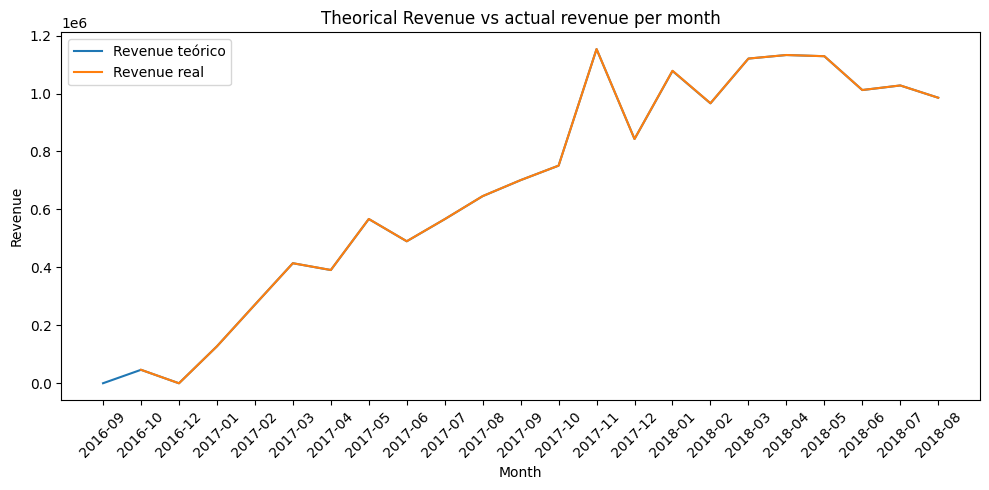

In [9]:
plt.figure(figsize=(10,5))

plt.plot(df_rev["year_month"], df_rev["theoretical_revenue"], label="Revenue teórico")
plt.plot(df_rev["year_month"], df_rev["actual_revenue"], label="Revenue real")

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Theorical Revenue vs actual revenue per month")
plt.legend()
plt.tight_layout()
plt.show()

From a visual analysis, the differences between expected and actual payments do not appear to be significant

## Business Performance Over Time

In [10]:
query = """
SELECT
    strftime('%Y-%m', date) AS year_month,
    COUNT(*) AS orders,
    SUM(total_paid) AS revenue
FROM fact_orders
WHERE total_paid IS NOT NULL
GROUP BY year_month
ORDER BY year_month;
"""


df_monthly = pd.read_sql(query, conn)


* Monthly revenue:

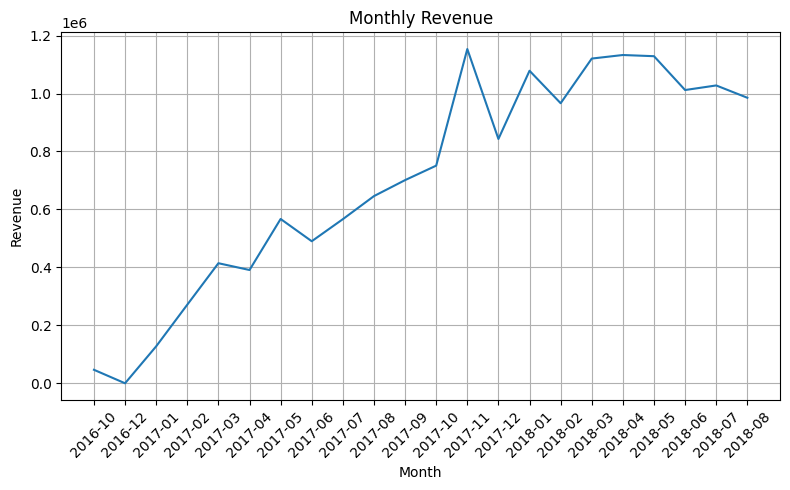

In [11]:
plt.figure(figsize=(8,5))
plt.plot(df_monthly["year_month"], df_monthly["revenue"])
plt.xticks(rotation=45)
plt.title("Monthly Revenue")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.grid()
plt.show()

Revenue shows a general upward trend over time. Although the growth is not strictly linear and includes temporary declines, it tends to recover and maintain a long-term increasing trajectory.

* Monthly orders

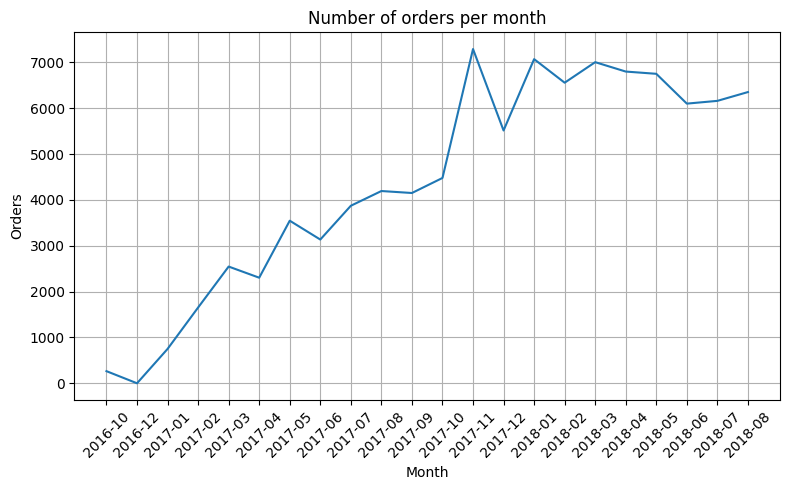

In [12]:
plt.figure(figsize=(8,5))
plt.plot(df_monthly["year_month"], df_monthly["orders"])
plt.xticks(rotation=45)
plt.title("Number of orders per month")
plt.xlabel("Month")
plt.ylabel("Orders")
plt.tight_layout()
plt.grid()
plt.show()

The resulting curve is similar to the time vs. revenue trend, which is expected given the relationship between the number of orders and the total payment amount.

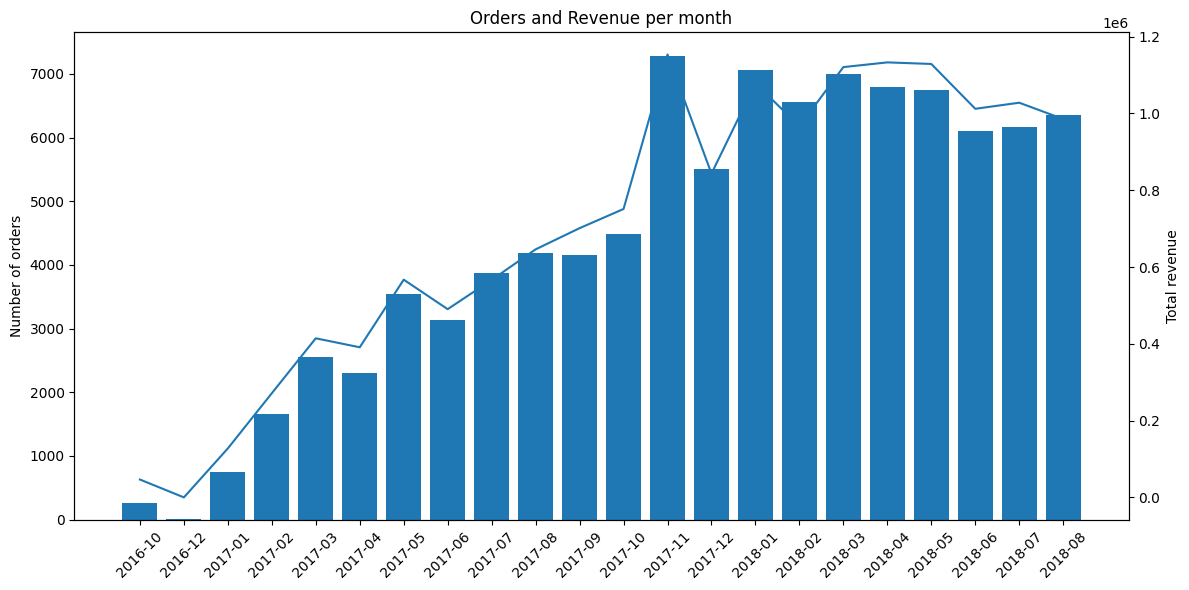

In [13]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(df_monthly["year_month"], df_monthly["orders"])
ax1.set_ylabel("Number of orders")

plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_monthly["year_month"], df_monthly["revenue"])
ax2.set_ylabel("Total revenue")

plt.title("Orders and Revenue per month")

plt.tight_layout()
plt.show()

The same plots as before, but displayed using a dual-axis chart.

## Payment method's distribution

In [14]:
query = """
SELECT
    payment_types,
    COUNT(*) AS orders,
    SUM(total_paid) AS revenue
FROM fact_orders
WHERE total_paid IS NOT NULL
GROUP BY payment_types
ORDER BY revenue DESC;
"""


df_ptypes = pd.read_sql(query, conn)

To generate the plot, it was necessary to include the clause WHERE total_paid IS NOT NULL to filter out missing values.

In [15]:
query = """
SELECT
    COUNT(*) AS order_null
FROM fact_orders
WHERE total_paid IS NULL;
"""

df_nulls = pd.read_sql(query, conn)

df_nulls

,order_null
0,1


An order was found with a NULL total payment.

Now, we proceed to generate the plot.

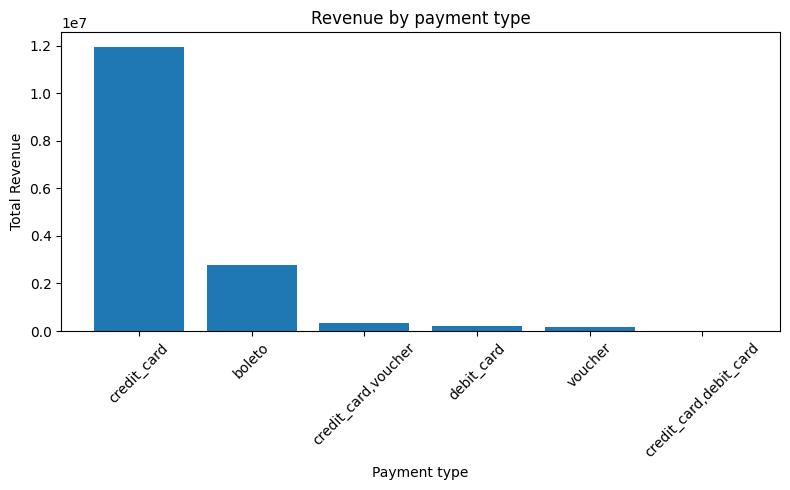

In [16]:
plt.figure(figsize=(8,5))

plt.bar(df_ptypes["payment_types"], df_ptypes["revenue"])

plt.title("Revenue by payment type")
plt.xlabel("Payment type")
plt.ylabel("Total Revenue")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

It is observed that credit_card is the payment type associated with the highest total amounts by a wide margin.

It is also interesting to create a bar chart where the y-axis represents the number of orders.

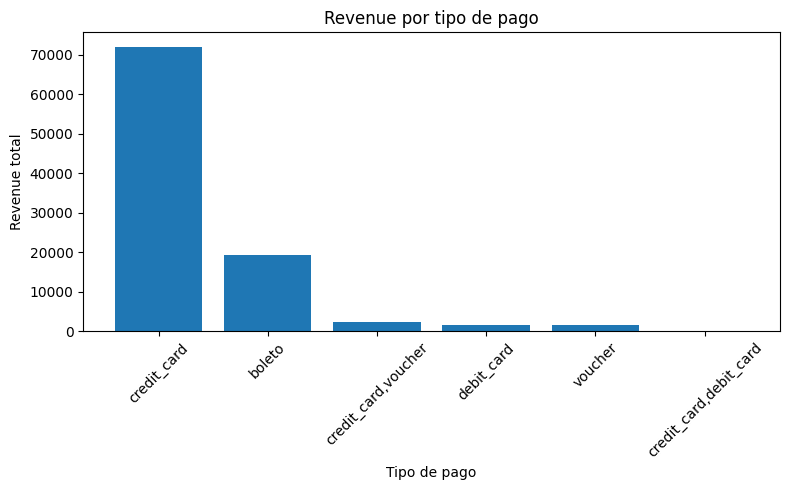

In [17]:
plt.figure(figsize=(8,5))

plt.bar(df_ptypes["payment_types"], df_ptypes["orders"])

plt.title("Revenue por tipo de pago")
plt.xlabel("Tipo de pago")
plt.ylabel("Revenue total")

plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

As expected, the plot is similar to the revenue chart.

## Geographic analysis

In [18]:
query = """
SELECT 
    customer_state,
    SUM(total_paid) AS revenue,
    AVG(total_paid) AS avg_ticket,
    COUNT(*) AS orders
FROM fact_orders
GROUP BY customer_state
ORDER BY revenue DESC; 
"""


df_geo = pd.read_sql(query, conn)

### State vs Revenue

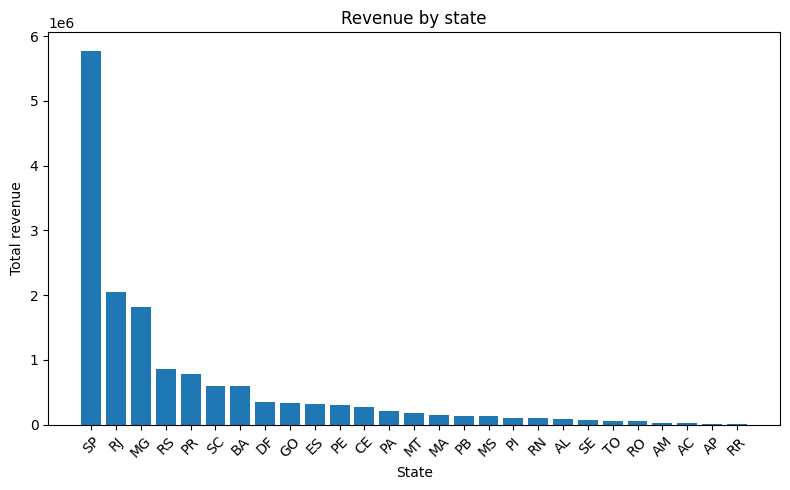

In [19]:
plt.figure(figsize=(8,5))

plt.bar(df_geo["customer_state"], df_geo["revenue"])

plt.title("Revenue by state")
plt.xlabel("State")
plt.ylabel("Total revenue")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

It is observed that São Paulo is the state where the highest revenue is generated, by a wide margin.

### State vs Average ticket

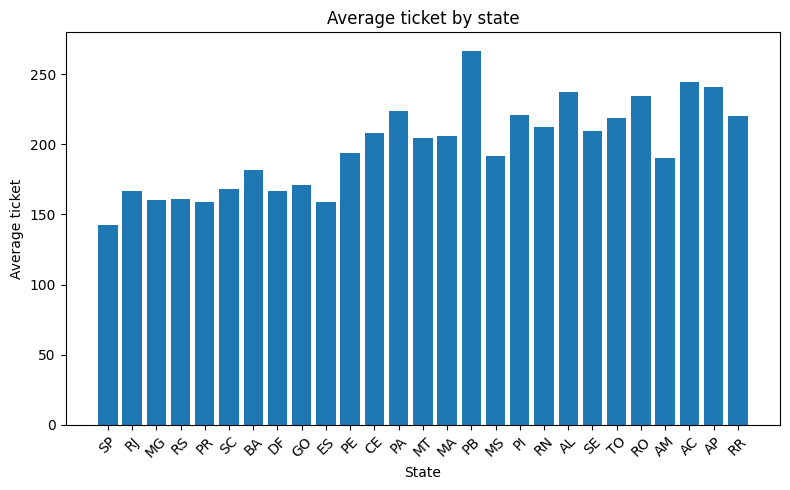

In [20]:
plt.figure(figsize=(8,5))

plt.bar(df_geo["customer_state"], df_geo["avg_ticket"])

plt.title("Average ticket by state")
plt.xlabel("State")
plt.ylabel("Average ticket")

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

We observe that the state generating the highest total revenue is not necessarily the one with the highest average ticket value. However, the average ticket values appear to be relatively balanced across states.

## Average ticket and distribution

In [21]:
query = """
SELECT total_paid
FROM fact_orders
WHERE total_paid IS NOT NULL;
"""

df_totPaid = pd.read_sql(query, conn)

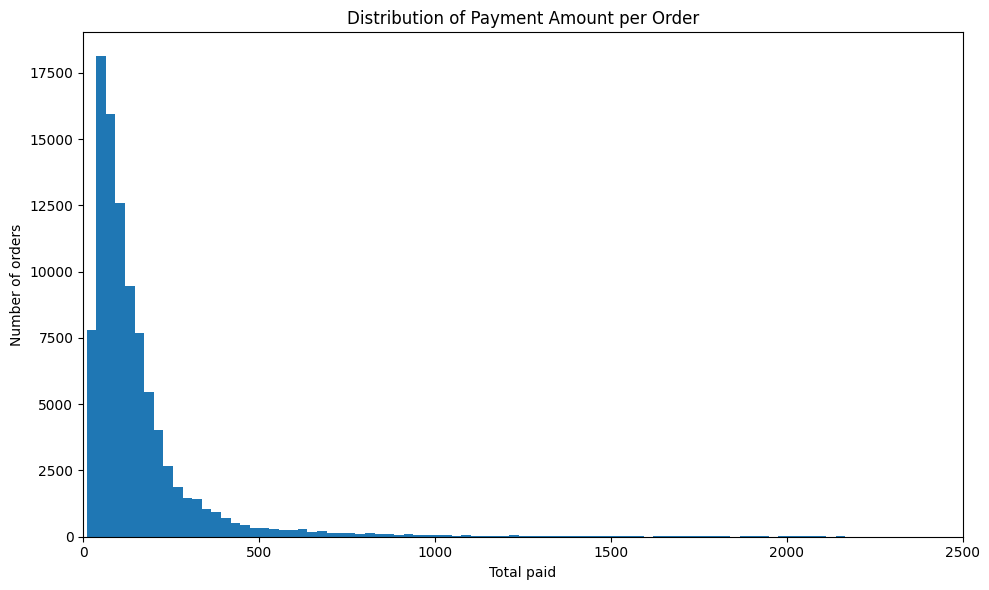

In [22]:
plt.figure(figsize=(10,6))

plt.hist(df_totPaid["total_paid"], bins=500)
plt.xlim(right = 2500, left = 0)
#plt.xscale("log")

plt.title("Distribution of Payment Amount per Order")
plt.xlabel("Total paid")
plt.ylabel("Number of orders")

plt.tight_layout()
plt.show()

In [23]:
df_totPaid["total_paid"].describe()

count    96477.000000
mean       159.856357
std        218.813144
min          9.590000
25%         61.880000
50%        105.280000
75%        176.330000
max      13664.080000
Name: total_paid, dtype: float64

From the histogram, we observe a long-tailed distribution that is right-skewed. We will attempt to approximate it using a known statistical distribution.

* Look logarithm...

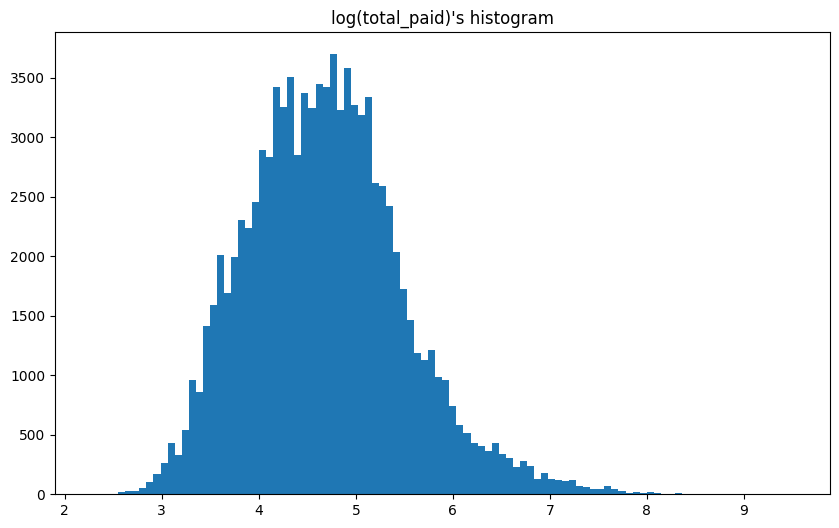

In [24]:
plt.figure(figsize=(10,6))
plt.hist(np.log(df_totPaid["total_paid"]), bins=100)
plt.title("log(total_paid)'s histogram")
plt.show()

By visual inspection, the distribution appears to follow a normal distribution.

### QQ-plot

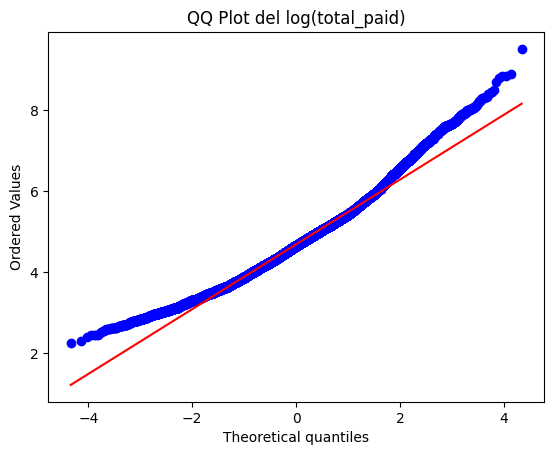

In [25]:
stats.probplot(np.log(df_totPaid["total_paid"]), dist="norm", plot=plt)
plt.title("QQ Plot del log(total_paid)")
plt.show()

The QQ plot of log(total_paid) shows a good fit in the central region but noticeable deviations in the tails, indicating the presence of heavy tails and frequent extreme values—behavior that is typical in e-commerce spending distributions.

## Delivery time

In [26]:
query = """
SELECT 
    date,
    order_delivered_customer_date
FROM fact_orders
WHERE order_delivered_customer_date IS NOT NULL;
"""

df_delivery = pd.read_sql(query, conn)

* transform dates:

In [27]:
df_delivery["date"] = pd.to_datetime(df_delivery["date"])

df_delivery["order_delivered_customer_date"] = pd.to_datetime(
    df_delivery["order_delivered_customer_date"])

* create feature delivery time:

In [28]:
df_delivery["delivery_days"] = (
    df_delivery["order_delivered_customer_date"] -
    df_delivery["date"]
).dt.days

df_delivery["delivery_days"].describe()

count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_days, dtype: float64

* Clean outliers

In [29]:
df_delivery = df_delivery[
    (df_delivery["delivery_days"] >= 0) &
    (df_delivery["delivery_days"] <= 60)
]

* Histogram:

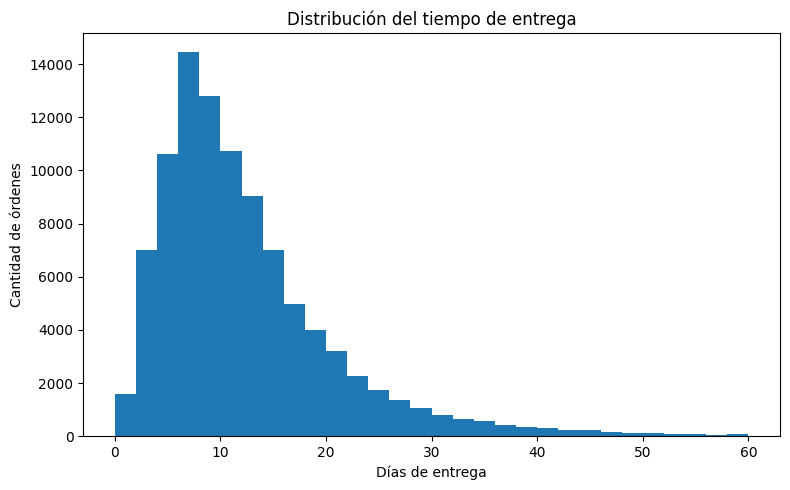

In [30]:
plt.figure(figsize=(8,5))

plt.hist(df_delivery["delivery_days"], bins=30)

plt.title("Distribución del tiempo de entrega")
plt.xlabel("Días de entrega")
plt.ylabel("Cantidad de órdenes")

plt.tight_layout()
plt.show()

We observe that most orders are delivered within a range of 6 to 15 days.

### Delivery time by state

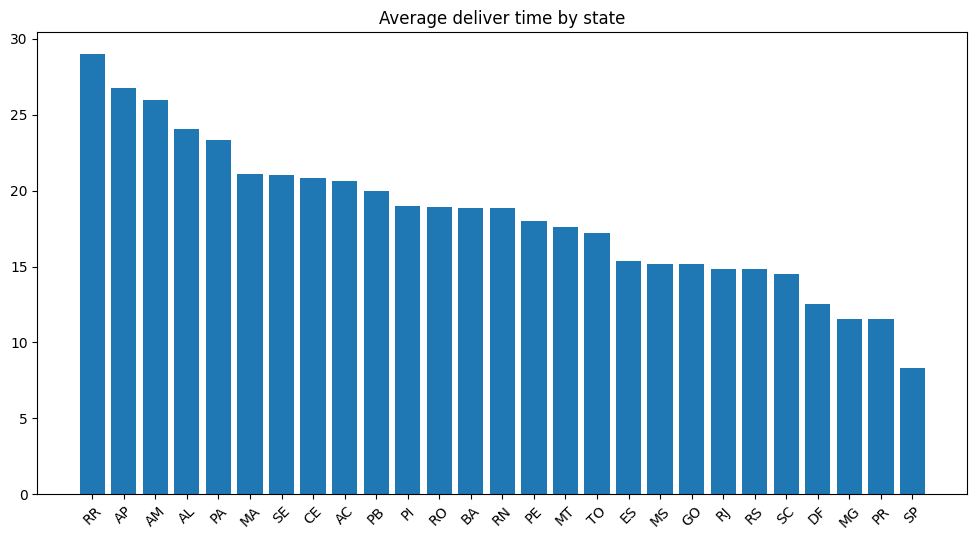

In [31]:
query = """
SELECT
    customer_state,
    date,
    order_delivered_customer_date
FROM fact_orders
WHERE order_delivered_customer_date IS NOT NULL
"""

df_state = pd.read_sql_query(query, conn)

df_state["date"] = pd.to_datetime(df_state["date"])
df_state["order_delivered_customer_date"] = pd.to_datetime(
    df_state["order_delivered_customer_date"]
)

df_state["delivery_days"] = (
    df_state["order_delivered_customer_date"] -
    df_state["date"]
).dt.days

avg_delivery = (
    df_state.groupby("customer_state")["delivery_days"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
plt.bar(avg_delivery.index, avg_delivery.values)

plt.title("Average deliver time by state")
plt.xticks(rotation=45)

plt.show()


We observe that São Paulo, which has the highest number of orders, also has the shortest average delivery time. Conversely, the state with the fewest orders shows the longest average delivery time.